# nfl-week1
#### Developed by Sam Isenberg, last updated 09/2018

This code scrapes all 32 NFL subreddits for a given time frame (keeping in mind Reddit's post-scraping limit) and performs sentiment analysis on each individual comment. Results are aggregated and analyzed on a per-team, per-post, and per-comment level, respectively.

A full description of the project can be found at [**saisenberg.com**](http://saisenberg.com/projects/nfl-week1.html).

#### Contents:  
1. Dependencies
2. Scraper and secondary function preparation
3. Data collection and aggregation
4. Analysis of results

### 1. Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import praw
import re
import sys
import unicodedata

from datetime import datetime, timedelta
from nltk import tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud

### 2. Scraper and secondary function preparation

In [2]:
# Start and end
team_data = pd.read_csv('./data/team_data_week1.csv')

nfldict = team_data.transpose()
nfldict.columns = nfldict.loc['Subreddit']
nfldict = nfldict.reindex(nfldict.index.drop('Subreddit'))
nfldict = nfldict.to_dict()

In [3]:
# Comment cleaning operations

# Asterisks (bold, italics, lists)
def removeAsterisks(text):
    return(re.sub(r'[*]', '', text))

# Tildes (strikethrough)
def removeStrikethrough(text):
    return(re.sub(r'[~]', '', text))

# Subscript
def removeSubscript(text):
    return(re.sub(r'[\^]', '', text))

# Quoted text
def removeQuotes(text):
    return(re.sub(r'>.*\n\n', '', text))
    
# New lines (\n\n) and all links (http...)
def removeNewLines(text):
    text = (' '.join(word for word in text.split() if not (word.startswith('http'))))
    text = re.sub('\(http.*\)', '', text)
    text = re.sub('http[^ ]*', '', text)
    return(text)

# Miscellaneous punctuation
def removeMiscellaneous(text):
    text = re.sub(r'\[|\]|#', '', text)
    text = re.sub('\&x200B\;', '', text)
    text = re.sub("['\"]", "'", text)
    return(text)

# Perform all cleaning
def cleanText(text):
    text = removeAsterisks(text)
    text = removeStrikethrough(text)
    text = removeSubscript(text)
    text = removeQuotes(text)
    text = removeNewLines(text)
    text = removeMiscellaneous(text)
    return(text)

# Contractions
def decontracted(text):
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"let\'s", "let us", text)
    
    text = re.sub(r"won’t", "will not", text)
    text = re.sub(r"can\’t", "can not", text)
    text = re.sub(r"let\’s", "let us", text)
    

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    text = re.sub(r"n\’t", " not", text)
    text = re.sub(r"\’re", " are", text)
    text = re.sub(r"\’s", " is", text)
    text = re.sub(r"\’d", " would", text)
    text = re.sub(r"\’ll", " will", text)
    text = re.sub(r"\’t", " not", text)
    text = re.sub(r"\’ve", " have", text)
    text = re.sub(r"\’m", " am", text)
    
    return text

# Tokenize and set stopwords
stops = stopwords.words('english')

def tokenizeAndStopwords(text, team):
    text = text.lower()
    text = tokenize.word_tokenize(text)
    text = [word for word in text if word not in 'super']
    
    # Remove "Luck" from all Colts comments (inflates positive sentiment)
    if team == 'colts':
        text = [word for word in text if word not in 'luck']
    
    return(text)

In [4]:
# Categorize comment by length and polarity
def categorizeComment(x, short, medium, long, pos_neg=0.40):
    
    # Comment length
    if (x['nchar'] >= short) & (x['nchar'] <= medium):
        comment_length = 'short'
    elif (x['nchar'] >= medium+1) & (x['nchar'] <= long):
        comment_length = 'medium'
    elif (x['nchar'] >= long+1) & (x['nchar'] <= np.inf):
        comment_length = 'long'
    else:
        comment_length = 'ERROR'

    # Comment polarity
    if (x['pos'] >= pos_neg) & (x['neg'] < pos_neg):
        comment_polarity = 'pos'
    elif (x['neg'] >= pos_neg) & (x['pos'] < pos_neg):
        comment_polarity = 'neg'
    elif (x['pos'] < pos_neg) & (x['neg'] < pos_neg):
        comment_polarity = 'neu'
    elif (x['pos'] >= pos_neg) & (x['neg'] >= pos_neg):
        comment_polarity = 'both'
    else:
        comment_polarity = 'ERROR'

    return(comment_length, comment_polarity)

In [5]:
# Word cloud of topic titles
def wordCloud(team, background_color="black"):
    
    topics = pd.DataFrame(nfldict[team]['topics'])
    cols = ['topic_body', 'topic_comments', 'topic_created', 'topic_id', 'topic_score', 'title', 
            'url']
    topics.columns = cols
    numeric_cols = ['topic_comments', 'topic_score']
    topics[numeric_cols] = topics[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
    
    topics = list(topics['title'])
    all_words = ' '.join(topics)

    nicklong = nfldict[team]['Nickname']
    nickshort = nicklong[0:len(nicklong)-1]
    city = nfldict[team]['City']
    wc_stops = stops + [nicklong, nickshort, city]

    wc = WordCloud(width = 600, height = 600, colormap=nfldict[team]['color_scheme'],
                    background_color = background_color, 
                    stopwords = wc_stops,
                    min_font_size = 30, 
                    random_state=1,).generate(all_words)
    
    plt.figure(figsize = (9, 9), facecolor = None) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

In [6]:
# Find the most common words in team comments of a given polarity
def commonWords(team_name, polarity, num_words):
    
    full_data = pd.DataFrame(nfldict[team_name]['full_data'])
    cols = ['body', 'comm_id', 'comm_created', 'comment_score', 'topic_id', 'body_clean', 
        'body_tokenized', 'comment', 'compound', 'neg', 'neu', 'pos', 'nchar', 'length', 
        'polarity', 'len_pol', 'topic_body','topic_comms_num', 'topic_created', 'topic_id', 
        'topic_score', 'title', 'url', 'comm_datetime', 'comm_date', 'comm_time', 'topic_datetime',
        'topic_date', 'topic_time']
    full_data.columns = cols
    numeric_cols = ['comment_score', 'compound', 'neg', 'neu', 'pos', 'nchar', 'topic_comms_num', 'topic_score']
    full_data[numeric_cols] = full_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
    
    words = list(full_data[full_data.polarity == polarity].comment)
    words = ' '.join(words)
    words = tokenize.word_tokenize(words)
    words = [word for word in words if word not in stops]
    words = FreqDist(words)
    words
    return(words.most_common(10))

### 3. Data collection and aggregation

Fill the below PRAW scraper with your app and account details. If necessary, visit [Reddit](https://www.reddit.com/prefs/apps) to create an app.

In [7]:
# Initialize reddit scraper
reddit = praw.Reddit(client_id='XXXXXX', 
                     client_secret='XXXXXX', 
                     user_agent='XXXXXX', 
                     username='XXXXXX', 
                     password='XXXXXX')

For a given NFL subreddit, *fullScraper* scrapes all available Reddit posts and comments within the appropriate time frame, and performs sentiment analysis on each comment with *nltk*.

In [8]:
def fullScraper(team):
    
    # Reset the dictionary for that team
    nfldict[team] = {key: nfldict[team][key] for key in ('City', 'Nickname', 'color_scheme', 
                                                         'start_month', 'start_day', 'start_hour',
                                                         'start_minute')}
    
    # Game time start/end
    start_month = nfldict[team]['start_month']
    start_day = nfldict[team]['start_day']
    start_hour = nfldict[team]['start_hour']
    start_minute = nfldict[team]['start_minute']
    
    start = datetime(2018, start_month, start_day, start_hour, start_minute, 0)
    end = start + timedelta(days=1)
    start = start.timestamp()
    end = end.timestamp()
    
    # Scrape submissions (up to 1000 limit)
    print('Starting subreddit: r/', team, sep='')
    subreddit = reddit.subreddit(team)
    team_new = subreddit.new(limit=1000)
    
    # Collect information about each post
    topics_dict = { "title":[], "score":[], "id":[], "url":[], "comms_num": [], 
               "created": [], "body":[] }

    for submission in team_new:

        if (submission.created < start) | (submission.created > end):
            pass

        else:
            topics_dict["title"].append(submission.title)
            topics_dict["score"].append(submission.score)
            topics_dict["id"].append(submission.id)
            topics_dict["url"].append(submission.url)
            topics_dict["comms_num"].append(submission.num_comments)
            topics_dict["created"].append(submission.created)
            topics_dict["body"].append(submission.selftext)

    topics = pd.DataFrame(topics_dict)
    nfldict[team]['topics'] = np.array(topics)
    
    # Collect information about all post comments
    comms_dict = { "topic": [], "body":[], "comm_id":[], "created":[], "score":[]}

    num = 0

    #for topic in topics_dict['id'][0:20]:
    for topic in topics_dict['id']:

        num = num + 1
        if num % 50 == 0:
            print('r/', team, ': Collecting comment #', num, sep='')

        submission = reddit.submission(id=topic)
        submission.comments.replace_more(limit=0)

        for comment in submission.comments.list():

            comms_dict["topic"].append(topic)
            comms_dict["body"].append(comment.body)
            comms_dict["comm_id"].append(comment)
            comms_dict["created"].append(comment.created)
            comms_dict['score'].append(comment.score)
    
    print('r/', team, ': Done collecting ', num, " comments", sep='')
        
    # Turn comments to dataframe
    comms = pd.DataFrame.from_dict(comms_dict)

    # Remove all deleted comments
    comms = comms[~comms['body'].isin(['[deleted]', '[removed]'])].reset_index(drop=True)
    
    # Collect and clean comment bodies
    bodies = list(comms['body'])
    bodies_clean = list(map(lambda x: cleanText(x), bodies))
    bodies_clean = [decontracted(text) for text in bodies_clean]
    
    # Remove remaining punctuation
    punc = dict.fromkeys(i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P'))

    punc = dict.fromkeys(punc, " ")
    bodies_clean = [text.translate(punc) for text in bodies_clean]
    bodies_clean = [text.replace('  ', ' ') for text in bodies_clean]
    bodies_clean = [text.strip() for text in bodies_clean]
    
    # Add new column of cleaned comments
    comms['body_clean'] = bodies_clean       
    tokenized_list = []
    for i in comms['body_clean']:
        tokenized_list.append(tokenizeAndStopwords(i, team))
    comms['body_tokenized'] = pd.Series(tokenized_list)
     
    print('r/', team, ': Done cleaning comments', sep='')
    
    # Sentiment analysis
    results = []

    sia = SIA()

    for line in list(comms['body_tokenized']):
        line_list = ' '.join(line)

        polarity = sia.polarity_scores(line_list)
        polarity['comment'] = ' '.join(line)

        results.append(polarity)

    results = pd.DataFrame(results)
    results['nchar'] = results.apply(lambda x: len(x['comment']), axis=1)

    print('r/', team, ': Done performing sentiment analysis', sep='')

    # Bins for comment length and polarity
    short = 0
    medium = np.percentile(np.array(results.nchar),(100/3))
    long = np.percentile(np.array(results.nchar),(200/3))

    results['length'] = results.apply(lambda x: categorizeComment(x, short=short, medium=medium, long=long)[0], axis=1)
    results['polarity'] = results.apply(lambda x: categorizeComment(x, short=short, medium=medium, long=long)[1], axis=1)
    results['len_pol'] = results.apply(lambda x: x['length'] + '_' + x['polarity'], axis=1)
    
    # Collect full merged data
    merged_1 = pd.merge(comms, results, left_index=True, right_index=True)
    merged_2 = pd.merge(merged_1, topics, left_on='topic', right_on='id')
    cols = ['body', 'comm_id', 'comm_created', 'comment_score', 'topic_id', 'body_clean', 'body_tokenized', 
            'comment', 'compound', 'neg', 'neu', 'pos', 'nchar', 'length', 'polarity', 'len_pol', 'topic_body', 
            'topic_comms_num', 'topic_created', 'topic_id', 'topic_score', 'title', 'url']
    merged_2.columns = cols

    # Add additional columns to full merged data
    merged_2['comm_datetime'] = merged_2.apply(lambda x: datetime.fromtimestamp(x['comm_created']), axis=1)
    merged_2['comm_date'] = merged_2.apply(lambda x: x['comm_datetime'].date(), axis=1)
    merged_2['comm_time'] = merged_2.apply(lambda x: x['comm_datetime'].time(), axis=1)
    merged_2['topic_datetime'] = merged_2.apply(lambda x: datetime.fromtimestamp(x['topic_created']), axis=1)
    merged_2['topic_date'] = merged_2.apply(lambda x: x['topic_datetime'].date(), axis=1)
    merged_2['topic_time'] = merged_2.apply(lambda x: x['topic_datetime'].time(), axis=1)
    
    nfldict[team]['full_data'] = np.array(merged_2)

For a given NFL subreddit, *subredditStats* utilizes the output of *fullScraper* to create team, topic, and comment-specific sentiment statistics.

In [9]:
# Collect all subreddit stats
def subredditStats(team):
    full_data = pd.DataFrame(nfldict[team]['full_data'])
    cols = ['body', 'comm_id', 'comm_created', 'comment_score', 'topic_id', 'body_clean', 
        'body_tokenized', 'comment', 'compound', 'neg', 'neu', 'pos', 'nchar', 'length', 
        'polarity', 'len_pol', 'topic_body','topic_comms_num', 'topic_created', 'topic_id', 
        'topic_score', 'title', 'url', 'comm_datetime', 'comm_date', 'comm_time', 'topic_datetime',
        'topic_date', 'topic_time']
    full_data.columns = cols
    
    topics = pd.DataFrame(nfldict[team]['topics'])
    cols = ['topic_body', 'topic_comments', 'topic_created', 'topic_id', 'topic_score', 'title', 
            'url']
    topics.columns = cols
 
    # Convert string columns to numeric columns
    numeric_cols = ['comment_score', 'compound', 'neg', 'neu', 'pos', 'nchar', 'topic_comms_num', 'topic_score']
    full_data[numeric_cols] = full_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
    numeric_cols = ['topic_comments', 'topic_score']
    topics[numeric_cols] = topics[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)
    
    # Crosstab
    ct = pd.crosstab(full_data['polarity'], full_data['length'])
    nfldict[team]['ct'] = ct

    # Crosstab by polarity
    ct_polarity = pd.crosstab(full_data['polarity'], full_data['length'], normalize='index')
    nfldict[team]['ct_polarity'] = ct_polarity

    # Crosstab by comment length
    ct_length = pd.crosstab(full_data['polarity'], full_data['length'], normalize='columns')
    nfldict[team]['ct_length'] = ct_length

    # Overall mean sentiment scores
    mean_pos = full_data['pos'].mean()
    mean_neg = full_data['neg'].mean()
    nfldict[team]['mean_pos'] = mean_pos
    nfldict[team]['mean_neg'] = mean_neg

    # Mean sentiment scores by comment sentiment
    mean_pos_by_sentiment = full_data.groupby('polarity')['pos'].mean()
    mean_neg_by_sentiment = full_data.groupby('polarity')['neg'].mean()
    nfldict[team]['mean_pos_by_sentiment'] = mean_pos_by_sentiment
    nfldict[team]['mean_neg_by_sentiment'] = mean_neg_by_sentiment

    # Mean sentiment scores by comment length
    mean_pos_by_length = full_data.groupby('length')['pos'].mean()
    mean_neg_by_length = full_data.groupby('length')['neg'].mean()
    nfldict[team]['mean_pos_by_length'] = mean_pos_by_length
    nfldict[team]['mean_neg_by_length'] = mean_neg_by_length

    # Submissions with the most positive/negative comments
    topic_pos_stats = full_data.groupby(['title'])['pos'].agg([sum, np.mean])
    topic_pos_stats.columns = ['sum_pos', 'mean_pos']

    topic_neg_stats = full_data.groupby(['title'])['neg'].agg([sum, np.mean])
    topic_neg_stats.columns = ['sum_neg', 'mean_neg']

    topic_stats = pd.merge(topic_pos_stats, topic_neg_stats, left_index=True, right_index=True)
    topic_stats = pd.merge(topic_stats, topics, left_index=True, right_on='title')

    nfldict[team]['topic_stats'] = np.array(topic_stats)

    comms_num_median = topic_stats.topic_comments.median()

    # Find the 10 most positive and negative topics (with at least the median # of comments)
    most_pos_topics = topic_stats[topic_stats['topic_comments']>=comms_num_median].sort_values('mean_pos', ascending=False).head(10)
    most_neg_topics = topic_stats[topic_stats['topic_comments']>=comms_num_median].sort_values('mean_neg', ascending=False).head(10)
    nfldict[team]['most_pos_topics'] = most_pos_topics
    nfldict[team]['most_neg_topics'] = most_neg_topics    

    # Find the 10 most positive and negative comments (medium & long)
    most_pos_comments_medium = full_data[full_data['length'] == 'medium'].sort_values('pos', ascending=False).head(10)
    most_neg_comments_medium = full_data[full_data['length'] == 'medium'].sort_values('neg', ascending=False).head(10)
    most_pos_comments_long = full_data[full_data['length'] == 'long'].sort_values('pos', ascending=False).head(10)
    most_neg_comments_long = full_data[full_data['length'] == 'long'].sort_values('neg', ascending=False).head(10)
    nfldict[team]['most_pos_comments_medium'] = most_pos_comments_medium
    nfldict[team]['most_neg_comments_medium'] = most_neg_comments_medium
    nfldict[team]['most_pos_comments_long'] = most_pos_comments_long
    nfldict[team]['most_neg_comments_long'] = most_neg_comments_long

    # Find the 20 most common words in positive/negative/neutral comments
    common_words_pos = commonWords(team, 'pos', 20)
    common_words_neg = commonWords(team, 'neg', 20)
    common_words_neu = commonWords(team, 'neu', 20)

    nfldict[team]['common_words_pos'] = common_words_pos
    nfldict[team]['common_words_neg'] = common_words_neg
    nfldict[team]['common_words_neu'] = common_words_neu

    print('r/', team, ': Done calculating sentiment statistics', sep='')

*collectAllData* performs both the *fullScraper* and *subredditStats* functions for a given NFL subreddit.

In [10]:
# Function to scrape and collect stats for a given subreddit
def collectAllData(subreddit_name):
    fullScraper(subreddit_name)
    subredditStats(subreddit_name)

In [11]:
# Collect and analyze comments for all NFL teams
for team in nfldict:
    collectAllData(team)

### 4. Analysis of results

#### Teams

In [12]:
# Filter dictionary to only scraped teams
temp = {}

for team in nfldict:
    if 'full_data' in nfldict[team]:
        temp[team] = nfldict[team]
        
nfldict = temp

In [13]:
# Teams with most positive/negative mean sentiments
mean_pos = {}
for team in nfldict:
    mean_pos[team] = nfldict[team]['mean_pos']
    
mean_neg = {}
for team in nfldict:
    mean_neg[team] = nfldict[team]['mean_neg']
    
mean_sentiment = pd.DataFrame.from_dict([mean_pos, mean_neg]).transpose()
mean_sentiment.columns = ['mean_pos', 'mean_neg']
mean_sentiment['net_pos'] = mean_sentiment.apply(lambda x: x['mean_pos']-x['mean_neg'], axis=1)

# Merge with team-by-team week 1 results
week1_scores = pd.read_csv('C:\\Users\\Sam\\Documents\\DATA\\Reddit scraping\\Sports subreddit sentiment analysis\\week1_scores.csv')
mean_sentiment = pd.merge(mean_sentiment, week1_scores, left_index=True, right_on='Subreddit')

colors=np.where(mean_sentiment['Result']=="W", 'green', 'red')
colors=np.where(mean_sentiment['Result']=="T", 'orange', colors)

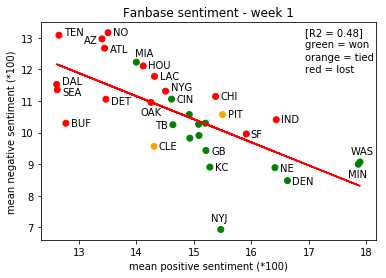

In [14]:
# Plot mean positive vs. negative sentiment

x = 100*mean_sentiment['mean_pos']
y = 100*mean_sentiment['mean_neg']

r2 = round(np.corrcoef(x, y)[0,1]**2,3)

plt.scatter(x=x, y=y, c=colors)
plt.xlabel('mean positive sentiment (*100)')
plt.ylabel('mean negative sentiment (*100)')
plt.title('Fanbase sentiment - week 1')

trendline = np.polyfit(x, y, 1)
trendlineplot = np.poly1d(trendline)
plt.plot(x, trendlineplot(x), "r")

plt.annotate('[R2 = %0.2f]' % r2, xy=(16.93, 13.10))
plt.annotate('green = won' % r2, xy=(16.93, 12.70))
plt.annotate('orange = tied' % r2, xy=(16.93, 12.30))
plt.annotate('red = lost' % r2, xy=(16.93, 11.90))

plt.annotate('MIN' % r2, xy=(17.68, 8.59))
plt.annotate('WAS' % r2, xy=(17.73, 9.32))
plt.annotate('NYJ' % r2, xy=(15.30, 7.19))
plt.annotate('DEN' % r2, xy=(16.70, 8.37))
plt.annotate('NE' % r2, xy=(16.50, 8.7925))
plt.annotate('KC' % r2, xy=(15.37, 8.82))
plt.annotate('IND' % r2, xy=(16.525, 10.32))
plt.annotate('SF' % r2, xy=(15.99, 9.85))
plt.annotate('GB' % r2, xy=(15.30, 9.32))
plt.annotate('PIT' % r2, xy=(15.59, 10.48))
plt.annotate('TB' % r2, xy=(14.32, 10.15))


plt.annotate('CHI' % r2, xy=(15.47, 11.05))
plt.annotate('TEN' % r2, xy=(12.74, 13.10))
plt.annotate('NO' % r2, xy=(13.60, 13.08))
plt.annotate('AZ' % r2, xy=(13.09, 12.85))
plt.annotate('ATL' % r2, xy=(13.54, 12.56))
plt.annotate('DAL' % r2, xy=(12.71, 11.52))
plt.annotate('SEA' % r2, xy=(12.72, 11.20))
plt.annotate('MIA' % r2, xy=(13.97, 12.43))
plt.annotate('HOU' % r2, xy=(14.21, 12.04))
plt.annotate('DET' % r2, xy=(13.56, 10.90))
plt.annotate('BUF' % r2, xy=(12.87, 10.21))
plt.annotate('LAC' % r2, xy=(14.41, 11.69))
plt.annotate('NYG' % r2, xy=(14.60, 11.33))
plt.annotate('OAK' % r2, xy=(14.07, 10.55))
plt.annotate('CIN' % r2, xy=(14.70, 10.97))
plt.annotate('CLE' % r2, xy=(14.38, 9.47))

plt.show()

In [15]:
# Sort teams by net mean positive sentiment
net_pos = mean_sentiment.sort_values('net_pos', ascending=True).loc[:, ['Subreddit', 'mean_pos', 'mean_neg', 'net_pos', 'Result']]
net_pos

,Subreddit,mean_pos,mean_neg,net_pos,Result
30,tennesseetitans,0.126554,0.130865,-0.004310,L
27,saints,0.135096,0.131669,0.003427,L
1,azcardinals,0.134037,0.129713,0.004324,L
13,falcons,0.134489,0.126754,0.007735,L
9,cowboys,0.126157,0.115281,0.010877,L
28,seahawks,0.126266,0.113590,0.012677,L
18,miamidolphins,0.140013,0.122317,0.017696,W
31,texans,0.141205,0.121127,0.020078,L
11,detroitlions,0.134722,0.110581,0.024141,L
5,buffalobills,0.127761,0.102964,0.024798,L


#### Posts

In [16]:
# Find the most negative posts
maxneg = pd.DataFrame()

for team in nfldict:
    team_maxneg = nfldict[team]['most_neg_topics']
    maxneg = maxneg.append(team_maxneg)

# Find the most negative posts (with at least 25 comments)
maxneg_topics = maxneg.loc[:,['topic_comments', 'mean_neg', 'title', 'url']].sort_values('mean_neg', ascending=False)
maxneg_topics = maxneg_topics[maxneg_topics['topic_comments']>25]
maxneg_topics.head(10)

,topic_comments,mean_neg,title,url
0,54,0.444750,IT’S FUCK THE JETS WEEK.,https://www.reddit.com/r/miamidolphins/comment...
339,33,0.359929,Everyone say it with me,https://i.redd.it/5o9sx9v5hil11.jpg
17,38,0.208921,Bills fans being classy towards Matt Judon...,https://imgur.com/a/lS6CXeu
58,31,0.206258,Tough loss but stay positive,https://www.reddit.com/r/oaklandraiders/commen...
19,49,0.195796,Video Of The Hit On Lewan,https://twitter.com/MySportsUpdate/status/1038...
17,32,0.194375,Dolphins Win! And ESPN puts the video of Dariu...,http://www.espn.com/nfl/team/_/name/mia/miami-...
17,26,0.192962,New England @ Jacksonville TV coverage map,https://i.redd.it/c4yvybuz2bl11.png
14,76,0.190569,Steelers Browns Tie! Cleveland remains winless...,https://www.reddit.com/r/bengals/comments/9egg...
108,33,0.184000,"David J. Chao, MD on Twitter: ""Cannot be sure ...",https://mobile.twitter.com/ProFootballDoc/stat...
57,71,0.178592,Ex-Eagle Mychal Kendricks pleads guilty to ins...,http://www2.philly.com/philly/news/crime/phila...


In [17]:
# Find the most positive posts
maxpos = pd.DataFrame()

for team in nfldict:
    team_maxpos = nfldict[team]['most_pos_topics']
    maxpos = maxpos.append(team_maxpos)

# Find the most positive posts with at least 25 comments
maxpos_topics = maxpos.loc[:,['topic_comments', 'mean_pos', 'title', 'url']].sort_values('mean_pos', ascending=False)
maxpos_topics = maxpos_topics[maxpos_topics['topic_comments']>25]
maxpos_topics.head(10)

,topic_comments,mean_pos,title,url
110,76,0.515068,VIKINGS SUICIDE PACT 2018 - Rules & etc.,https://www.reddit.com/r/minnesotavikings/comm...
40,69,0.502565,Phillip Dorsett becomes the 69th player to cat...,https://twitter.com/MikeReiss/status/103885819...
151,204,0.317546,Game day giveaway!,https://i.redd.it/j3wtezcug9l11.jpg
93,46,0.252022,Aaron Rodgers,https://www.reddit.com/r/CHIBears/comments/9ei...
57,38,0.241079,Patriots Texans 2018 Week 1 Gifs,https://www.reddit.com/r/Patriots/comments/9eg...
14,35,0.240686,Kansas City's Bitch,https://gfycat.com/NarrowPotableCheetah
21,38,0.238684,What are your thoughts leading into this weeks...,https://i.redd.it/w5lqu66ekfl11.jpg
27,62,0.234968,Marcus Peters pick six and the amazing celebra...,https://streamable.com/rm0qo
44,27,0.233692,Got Arrow in his jersey ready to watch the gam...,https://i.redd.it/jty65dtu1il11.jpg
98,53,0.230596,I'm going to my first Patriots game today!,https://www.reddit.com/r/Patriots/comments/9ec...


#### Comments

In [18]:
# Find the most negative comments of long length
maxneg2 = pd.DataFrame()

for team in nfldict:
    team_maxneg = nfldict[team]['most_neg_comments_long']
    maxneg2 = maxneg2.append(team_maxneg)

# Number of unique words per negative long comment
maxneg2['unique_words'] = maxneg2.apply(lambda x: len(set(x['body_tokenized'])), axis=1)

# Find the most negative comments with at least 25 upvotes
maxneg_comments = maxneg2.loc[:,['body', 'comment_score', 'nchar', 'neg', 
                                'unique_words', 'title', 'url']].sort_values('neg', ascending=False)
maxneg_comments = maxneg_comments[maxneg_comments['comment_score']>25]

maxneg_comments.head(10)

,body,comment_score,nchar,neg,unique_words,title,url
427,DIRTY FUCKING BULLSHIT. SHOVING YOUR HELMET IN...,26.0,99.0,0.534,18,Opening Day Game Thread: Dallas Cowboys (0-0) ...,https://www.reddit.com/r/panthers/comments/9ef...
549,"FUCK THE NFL PANSY RULES, FUCK THE REFS, FUCK ...",48.0,144.0,0.447,18,BENGALS WIN FEJEDELEM MVP UPVOTE PARTY,https://www.reddit.com/r/bengals/comments/9eg0...
1950,We force a punt and then pull that shit. Compl...,41.0,107.0,0.427,18,[Game Thread] Week 1: Atlanta Falcons (0-0) at...,https://www.reddit.com/r/eagles/comments/9dp06...
1126,Nagy needs his nuts chopped off for those 3rd ...,76.0,119.0,0.419,24,Week 1 Post-Gamethread: Bears at Packers,https://www.reddit.com/r/CHIBears/comments/9ej...
857,r/saints before the game: LMAO Falcons are awf...,136.0,170.0,0.417,28,Watching this game like,https://i.redd.it/zgjwne92l9l11.jpg
1945,Fuck all you bitches calling Cobb a $4M WR!!!!...,28.0,121.0,0.408,22,[Week 1] Post-Game Thread: Chicago Bears (0-1)...,https://www.reddit.com/r/GreenBayPackers/comme...
2103,Hahahahahahhhaha. Someone kill me. This is aw...,38.0,219.0,0.405,35,Game Thread: 2018 Week 1 at Carolina Panthers,https://www.reddit.com/r/cowboys/comments/9efw...
505,Listen the fuck up. Anybody here blaming Conne...,47.0,114.0,0.404,20,Today showed just how much Bell means to this ...,https://www.reddit.com/r/steelers/comments/9eg...
930,I said that same thing when I saw it happen. S...,28.0,193.0,0.402,34,Falcons' Grady Jarrett Gets Flagged For Not Le...,https://deadspin.com/falcons-grady-jarrett-get...
1936,I need this fucking guy cut immediately. Fuck ...,57.0,141.0,0.389,23,[Game Thread] Week 1: Atlanta Falcons (0-0) at...,https://www.reddit.com/r/eagles/comments/9dp06...


In [19]:
# Find the most positive comments of long length
maxpos2 = pd.DataFrame()

for team in nfldict:
    team_maxpos = nfldict[team]['most_pos_comments_long']
    maxpos2 = maxpos2.append(team_maxpos)

# Number of unique words per positive long comment
maxpos2['unique_words'] = maxpos2.apply(lambda x: len(set(x['body_tokenized'])), axis=1)

# Find the most positive comments with at least 25 upvotes
maxpos_comments = maxpos2.loc[:,['body', 'comment_score', 'nchar', 'pos', 'body_clean', 'unique_words', 'title', 'url']].sort_values('pos', ascending=False)
maxpos_comments = maxpos_comments[maxpos_comments['comment_score']>25]

maxpos_comments.head(10)

,body,comment_score,nchar,pos,body_clean,unique_words,title,url
220,Feeling pretty good about this. They played li...,54.0,114.0,0.572,Feeling pretty good about this They played lik...,20,Well 🤷🏻‍♂️,https://i.redd.it/8men0g1hobl11.jpg
222,Baltimore Ravens\t2000\t4-0\t12-4\tNFL Champio...,29.0,83.0,0.542,Baltimore Ravens 2000 4 0 12 4 NFL Champion W...,17,Congratulations to the Baltimore Ravens for be...,https://www.reddit.com/r/ravens/comments/9eh91...
547,I loved when McVay ran down there to hug Peter...,79.0,92.0,0.516,I loved when McVay ran down there to hug Peter...,19,Marcus Peters pick six and the amazing celebra...,https://streamable.com/rm0qo
1158,"Thank you! I posted it in the in game thread,...",31.0,135.0,0.514,Thank you I posted it in the in game thread bu...,26,Randall Cobb Appreciation Thread!,https://www.reddit.com/r/GreenBayPackers/comme...
127,Appreciate the respect. Your defensive line wa...,50.0,138.0,0.486,Appreciate the respect Your defensive line was...,21,I come in peace...,https://www.reddit.com/r/falcons/comments/9dtt...
1728,Lmao I'm not even upset. That is honestly the ...,50.0,100.0,0.482,Lmao I am not even upset That is honestly the ...,17,Game Thread: New York Jets at Detroit Lions,https://www.reddit.com/r/nyjets/comments/9ermx...
3205,As a Bears fan I’m really happy that he’s back...,66.0,118.0,0.472,As a Bears fan I am really happy that he is ba...,23,AARON RODGERS RETURNS TO FIELD IN PADS,https://www.reddit.com/r/GreenBayPackers/comme...
813,I just got engaged tonight and the jets win an...,57.0,106.0,0.468,I just got engaged tonight and the jets win an...,18,Post Game Thread: The New York Jets defeated T...,https://www.reddit.com/r/nyjets/comments/9etj4...
1597,"Just like the Mexican National Team.\n\n""Juega...",77.0,114.0,0.465,Just like the Mexican National Team Juegan co...,16,That time of year again,https://imgur.com/a3N5GeU
1131,I love being a lions fan. My favorite part was...,84.0,103.0,0.458,I love being a lions fan My favorite part was ...,20,New York Jets @ Detroit Lions - Official Postg...,https://www.reddit.com/r/detroitlions/comments...


#### Words

In [20]:
# Most common negative words
remove_neg = ['fuck', 'fucking', 'bad', 'damn', 'ass', 'shit', 'hell', 'bitch', 'yeah', 'holy', 
              'bullshit', '^fuck', '^the', '^jets', 'dick', 'fucked', 'man', 'na', 'game', 'one', 
              'oh', 'really', 'great', 'em', '1']

for team in nfldict:
    team_neg_words = [x for x in nfldict[team]['common_words_neg'] if x[0] not in remove_neg]
    team_neg_string = ''
    
    count = 0
    for word in team_neg_words:
        count = count + 1
        if count != len(team_neg_words):
            team_neg_string = team_neg_string + word[0] + ' (' + str(word[1]) + '), '
        else:
            team_neg_string = team_neg_string + word[0] + ' (' + str(word[1]) + ')'
    
    
    print(nfldict[team]['Nickname'], ' (r/', team, '): ', team_neg_string, sep='')

49ers (r/49ers): jimmy (5), cancer (4), injury (4)
Bears (r/chibears): hate (15), packers (10), loss (9), like (8), collinsworth (8)
Bengals (r/bengals): penalty (11), nfl (9), steelers (8), blah (6), dirty (4), refs (4)
Bills (r/buffalobills): tyrod (6), benjamin (5), feel (4), terrible (4), peterman (4)
Broncos (r/denverbroncos): raiders (6), von (6), offense (4), hate (3), go (3)
Browns (r/browns): hue (6), sucks (6), offense (6), right (5), win (5)
Buccaneers (r/buccaneers): fire (10), saints (10), smith (6), cannons (5), offense (5)
Cardinals (r/azcardinals): suck (9), rosen (7), bradford (7), riot (6), defense (6), mccoy (5)
Chargers (r/chargers): cut (5), hate (5), us (5), guy (4)
Chiefs (r/kansascitychiefs): defense (6), terrible (3), crazy (3), tyreek (3), killing (3), woes (3)
Colts (r/colts): get (5), mad (4), doyle (4), hit (4), team (3)
Cowboys (r/cowboys): fire (15), offense (13), romo (9), dak (9), every (8), single (8)
Dolphins (r/miamidolphins): jets (119), bills (29),

In [21]:
# Most common positive words
remove_pos = ['good', 'lol', 'great', 'like', 'love', 'thanks', 'thank', 'well', 'yes', 'yeah', 
              'nice', 'want', 'game', 'would']

for team in nfldict:
    team_pos_words = [x for x in nfldict[team]['common_words_pos'] if x[0] not in remove_pos]
    team_pos_string = ''
    
    count = 0
    for word in team_pos_words:
        count = count + 1
        if count != len(team_pos_words):
            team_pos_string = team_pos_string + word[0] + ' (' + str(word[1]) + '), '
        else:
            team_pos_string = team_pos_string + word[0] + ' (' + str(word[1]) + ')'
    
    
    print(nfldict[team]['Nickname'], ' (r/', team, '): ', team_pos_string, sep='')

49ers (r/49ers): defense (15), played (13)
Bears (r/chibears): please (27), bears (21), hope (18)
Bengals (r/bengals): win (16), luck (10), better (9), bengals (9), best (6)
Bills (r/buffalobills): allen (9), better (8), hope (7), fan (7)
Broncos (r/denverbroncos): von (14), win (13)
Browns (r/browns): win (17), hope (13), browns (11)
Buccaneers (r/buccaneers): win (9), happy (9), plays (8), bucs (7), fan (7)
Cardinals (r/azcardinals): defense (8), better (6), rosen (5), lmao (4), one (4), pretty (4)
Chargers (r/chargers): lmao (8), better (7), play (7), hope (7), team (7)
Chiefs (r/kansascitychiefs): pretty (11), win (11), mahomes (9), play (8), best (8), ok (8)
Colts (r/colts): defense (10), looked (9), andrew (9), man (8)
Cowboys (r/cowboys): dak (9), pretty (7), romo (7), better (7)
Dolphins (r/miamidolphins): win (11), looks (8), play (7), lmao (7)
Eagles (r/eagles): win (19), best (16), pretty (14), play (13), eagles (12)
Falcons (r/falcons): つ (36), ◕ (36), fan (13), take (12), 

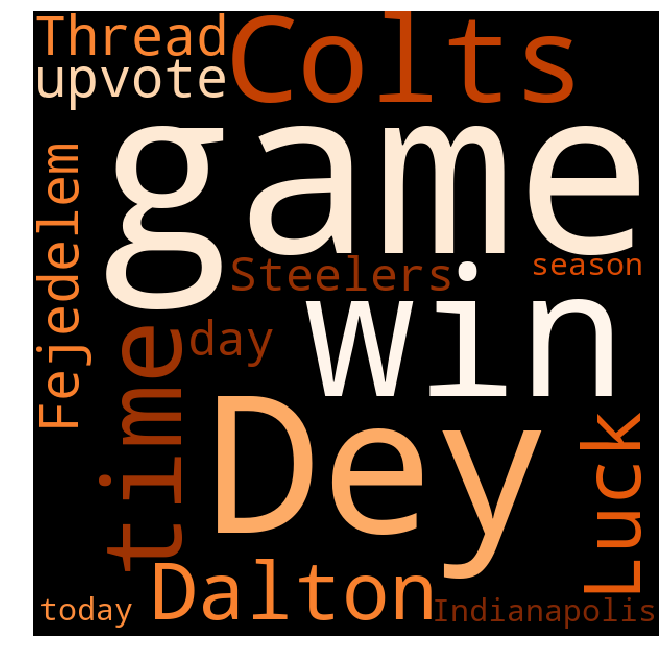

In [22]:
# Word cloud ex. 1
wordCloud('bengals')

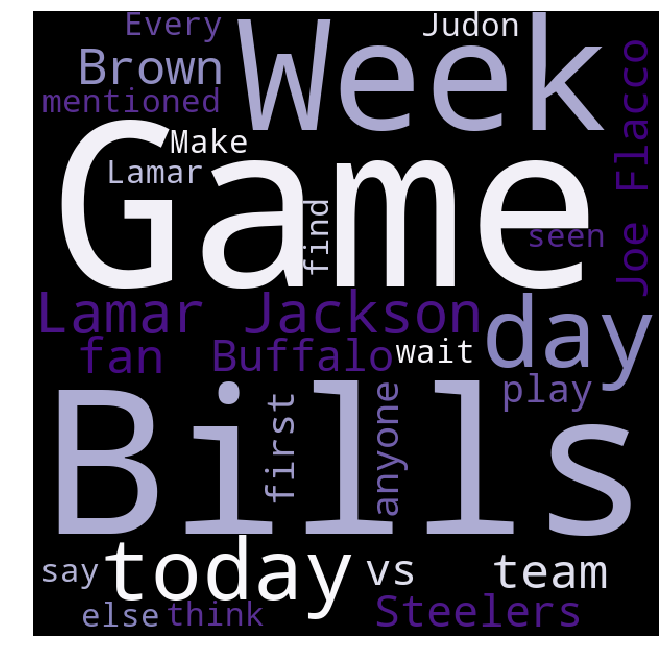

In [23]:
# Word cloud ex. 2
wordCloud('ravens')